In [77]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import seaborn as sb
from nltk.corpus import words, stopwords
import matplotlib.pyplot as plt
nltk.download('words')
nltk.download('stopwords')


[nltk_data] Downloading package words to /home/geovabe/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/geovabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read dataset

In [78]:
df = pd.read_csv('./SRC/IMDB Dataset.csv')
df = df.head(5000)

In [79]:
X = df['review']
y = df['sentiment']

## Analisys reviews

In [80]:
X[5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [81]:
dict_change = {}
dict_change['< br />'] = ''
dict_change['<br />'] = ''
dict_change["'ll"] = ' will'
dict_change["'s"] = ' is'
dict_change["'re"] = ' are'
dict_change["n't"] = ' not '


## Functions

#### Pre-processing

In [82]:
def basic_preprocessing(X, dict_change):
    new_x = []
    for i in X:
        text_lower = i.lower()
        for key in dict_change:
            if key in text_lower:
                text_lower.replace(key, dict_change[key])
        text_lower = re.sub("\W", ' ', text_lower)
        text_lower = re.sub(" +", ' ', text_lower)
        tokens = nltk.word_tokenize(text_lower)
        tokens = [x for x in tokens if x not in stopwords.words('english')]  
        new_x.append(' '.join(tokens))
    return new_x

In [83]:
def lemmatizer(X):
    lemmatizer = WordNetLemmatizer()
    new_x = []
    for i in X:
        tokens = nltk.word_tokenize(i)
        for j in range(len(tokens)):
            tokens[j] = lemmatizer.lemmatize(tokens[j])
        new_x.append(' '.join(tokens))
    return new_x

In [84]:
def remove_no_dict_words(X):
    words_valid = []
    words_invalid = []
    words_numpy = np.array(words.words())
    new_x = []
    for review in X:
        x_words = nltk.word_tokenize(review)
        for token in x_words:
            if token in words_valid:
                pass
            elif token in words_invalid:
                words_invalid.append(token)
                x_words.remove(token)
            elif token in words_numpy:
                words_valid.append(token)
            else:
                words_invalid.append(token)
                x_words.remove(token)
        new_x.append(' '.join(x_words))
    return new_x

#### Training

In [85]:
def simple_training(X, y, method, models, random_state):
    df = {
        'Model': [],
        'Accuracy': []
    }
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=random_state)
    
    for model in models:
        pipeline = make_pipeline(method, models[model])
        clf = pipeline.fit(X_train, y_train)
        df['Model'].append(model)
        df['Accuracy'].append(accuracy_score(y_test, clf.predict(X_test)))

    return pd.DataFrame(df)

In [86]:
def full_training(X, y,method, models, params,random_state, n_iter):
    df = {
        'Model':[],
        'Params': [],
        'Accuracy': [],
    }
    X = method.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=random_state)
    for model in models:
        clf = RandomizedSearchCV(models[model], params[model], n_iter=n_iter)
        clf.fit(X_train, y_train)
        predict = clf.predict(X_test)
        df['Model'].append(model)
        df['Params'].append(clf.best_estimator_)
        df['Accuracy'].append(accuracy_score(y_test, predict))
    return pd.DataFrame(df)

## Training 

#### Selecting models, params and preprocessing

In [87]:
models = {
    'MLP 1layer': MLPClassifier(max_iter=4000),
    'MLP 2layer': MLPClassifier(max_iter=4000),
    'SVC Linear': SVC(kernel='linear'),
    'SVC Poly': SVC(kernel='poly'),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision tree': DecisionTreeClassifier(),
}

In [88]:
pre_processing = ['Basic Preprocessing', 'Lematization', 'add removing no words']
preprocessed_data = []
X = basic_preprocessing(X, dict_change)

In [89]:
preprocessed_data.append(X)
preprocessed_data.append(lemmatizer(X))
preprocessed_data.append(remove_no_dict_words(lemmatizer(X)))

#### Simple training with Count and TF-IDF

In [90]:
dataframe = pd.DataFrame()
methods = [CountVectorizer(), TfidfVectorizer()]
for i in methods:
    for index, item in enumerate(preprocessed_data):
        dataframe_aux = simple_training(item, y, i, models, 42)
        dataframe_aux['Pre_Processing'] = pre_processing[index]
        dataframe_aux['Method'] = f'{i}'
        dataframe = pd.concat([dataframe, dataframe_aux], ignore_index=True)

(0.4, 0.91476)

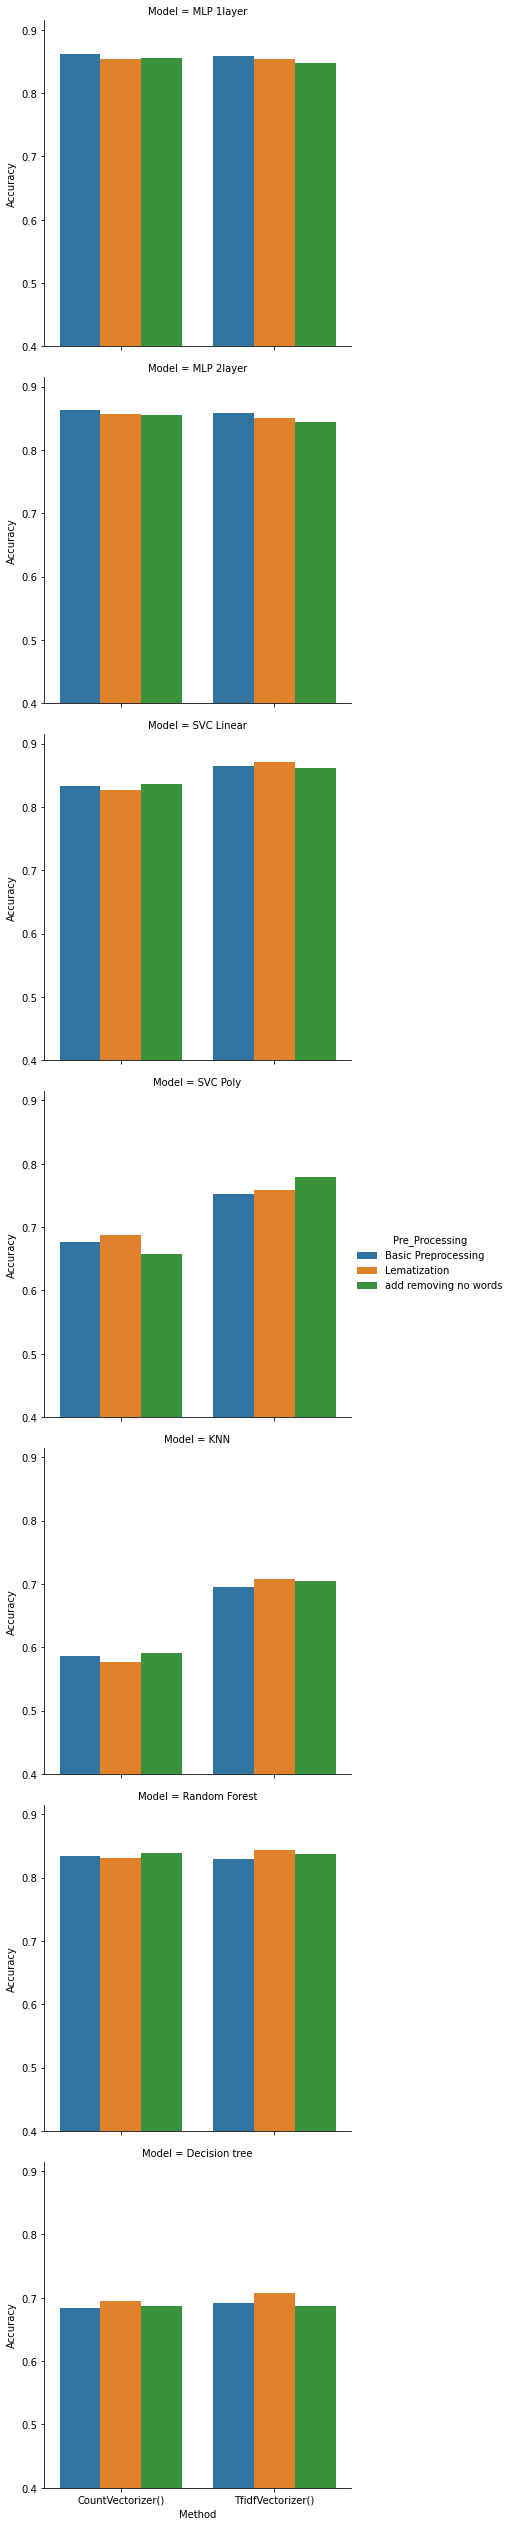

In [91]:
sb.catplot(data=dataframe, hue='Pre_Processing', y='Accuracy', x='Method', row='Model', kind='bar')
plt.ylim(0.4)

#### Selecting new models and params

In [92]:
models = {
    'SVC Linear': SVC(kernel='linear'),
}

In [93]:
from numpy.random import randint
C = [2 ** i for i in range(-5, 16,2)]
gamma = [2 ** i for i in range(-15, 4,2)]

In [94]:
import random
gamma = random.choices(gamma, k=3)
gamma.append('scale')
gamma.append('auto')

In [95]:
C = random.choices(C, k=3)

In [96]:
params = {
    'SVC Linear': {'gamma':gamma, 'C':C },
    'MLP 1layer': {'hidden_layer_sizes':[(x, ) for x in range(2,1000)]},
    'MLP 2layer': {'hidden_layer_sizes':[(randint(50,1000), randint(50,1000)) for x in range(2,1000)]},
}

#### Full training without mlp and plot

In [97]:
dataframe = pd.DataFrame()
methods = [CountVectorizer(), TfidfVectorizer()]
for i in methods:
    for index, item in enumerate(preprocessed_data):
        dataframe_aux = full_training(X,y,i,models,params,42,15)
        dataframe_aux['Pre_Processing'] = pre_processing[index]
        dataframe_aux['Method'] = f'{i}'
        dataframe = pd.concat([dataframe, dataframe_aux], ignore_index=True)

Text(0.5, 1.0, 'SVC with adjust Hiperparams')

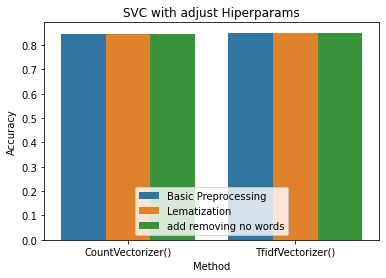

In [98]:
sb.barplot(x='Method', y='Accuracy', hue = 'Pre_Processing', data=dataframe)
plt.legend(loc='lower center')
plt.title(label='SVC with adjust Hiperparams')

## Results

This problem consists of analyzing a dataset with 50000 examples of film analysis. To deal with an NLP problem, the first step is to separate and clean the data. In this case I only took part of the data, 5000 is a good value due to the training time of the algorithms, but the recommended training is with the largest amount of data available. For a data clean, I left all letters in lowercase, removed html tags and compressed words and punctuation removed. Another pre-processing I did was lemmatization and finally I removed all the words that were not in the dictionary.
<br/><br/>
In an analysis of the results of rapid tests with several classifiers, we can see that the MLP and SVC classifiers obtained the best results, with an accuracy around 85%. For hyperparameter refinement it is unfeasible to use the MLP classifier due to excessive training time, if I reduce the amount of, the classifier will not perform well, therefore for hyperparameter optimization using SVC classifier with linear kernel, and I obtained an accuracy of almost 90% in the final result. With this precision I liked the result, so I closed this notebook.